In [42]:
import numpy as np
import pandas as pd

#To build the model
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset, random_split, WeightedRandomSampler

#For data manipulation
from data.CustomDataset.datasett import ChunkedStreamingDataset, TestNumpyDataset

#Progress
import tqdm
import time

#Validation and Metric
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

#Visualization
import matplotlib.pyplot as plt
from PIL import Image
import cv2

In [2]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("Using device:", device)

Using device: mps


## Preparing the Dataset

In [3]:
# Load labels
XTRAIN_DATA_PATH = "/Users/binit/PycharmProjects/FinalProject/Project_File/data/Xtrain_Image.npy"
XTEST_DATA_PATH = "/Users/binit/PycharmProjects/FinalProject/Project_File/data/Xtest_Image.npy"

YTRAIN_DATA_PATH = "/Users/binit/PycharmProjects/FinalProject/Project_File/data/ytrain.npy"
YTEST_DATA_PATH = "/Users/binit/PycharmProjects/FinalProject/Project_File/data/ytest.npy"

In [3]:
df_balanced = pd.read_pickle('df_balanced.pkl')

In [4]:
df_balanced.sample(5)

,path,cell_type_idx
15871,/Users/binit/PycharmProjects/FinalProject/Proj...,1
16817,/Users/binit/PycharmProjects/FinalProject/Proj...,2
3886,/Users/binit/PycharmProjects/FinalProject/Proj...,4
3379,/Users/binit/PycharmProjects/FinalProject/Proj...,4
13960,/Users/binit/PycharmProjects/FinalProject/Proj...,1


In [9]:
Xtrain, Xtest, ytrain, ytest = train_test_split(df_balanced['path'], df_balanced['cell_type_idx'], test_size=0.25, random_state=42)

In [10]:
df_balanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28749 entries, 0 to 28748
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   path           28749 non-null  object
 1   cell_type_idx  28749 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 449.3+ KB


In [49]:
len(Xtrain)

21561

In [11]:
IMG_SIZE = 224

standard_transform = transforms.Compose([                   
    transforms.Resize((224, 224)),
    transforms.ToTensor(),                     # Convert back to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], 
                         std=[0.5, 0.5, 0.5])
])

# Define a stronger augmentation transform (for minority classes)
strong_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.3),    # Higher probability of flip
    transforms.RandomRotation(20),             # More rotation
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
])

test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], 
                         std=[0.5, 0.5, 0.5])
])

In [12]:

#Compute class weights from entire dataset
all_labels = df_balanced['cell_type_idx']
unique_classes, class_counts = np.unique(all_labels, return_counts=True)
print(unique_classes, class_counts)
class_weights = 1.0 / torch.tensor(class_counts, dtype=torch.float32, device=device)
print('Class Weights:', class_weights)


[0 1 2 3 4 5 6] [3924 3598 3297 3910 6705 3339 3976]
Class Weights: tensor([0.0003, 0.0003, 0.0003, 0.0003, 0.0001, 0.0003, 0.0003],
       device='mps:0')


In [13]:
# Create test dataset
test_dataset = TestNumpyDataset(Xtest, ytest, base_transform=test_transforms, is_train=False)

# Create test dataloader
test_loader = DataLoader(test_dataset, batch_size=128, num_workers=0, pin_memory=True)

In [10]:
# First, split the DataFrame into training and validation sets:
Xtrain, Xval, ytrain, yval = train_test_split(
    df_balanced['path'], 
    df_balanced['cell_type_idx'], 
    test_size=0.2, 
    random_state=42, 
    stratify=df_balanced['cell_type_idx']
)

# Convert the splits to lists:
train_image_paths = Xtrain
train_labels = ytrain
val_image_paths = Xval
val_labels = yval

# Define minority classes (if needed):
minority_classes = [0, 1, 2, 3, 5, 6]

# Create the training dataset (applies extra augmentation for minority classes)
train_dataset = TestNumpyDataset(
    image_paths=train_image_paths,
    labels=train_labels,
    base_transform=standard_transform,
    minority_transform=strong_transform,
    minority_classes=minority_classes,
    is_train=True
)

# Create the validation dataset (only applies the standard transform)
val_dataset = TestNumpyDataset(
    image_paths=val_image_paths,
    labels=val_labels,
    base_transform=standard_transform,
    minority_transform=None,  # No extra augmentation for validation
    minority_classes=None,
    is_train=False
)

# Compute weights for the training dataset
train_labels_subset = [train_dataset[i][1].item() for i in range(len(train_dataset))]
unique_classes, counts = np.unique(train_labels_subset, return_counts=True)
c_w = 1. / torch.tensor(counts, dtype=torch.float32, device=device)
sample_weights = [c_w[label] for label in train_labels_subset]

sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=128, sampler=sampler, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=0, pin_memory=True)


In [14]:
batch = next(iter(train_loader))
images, labels = batch

# Print shapes and types
print("Images shape:", images.shape)   # Expected: (batch_size, channels, height, width)
print("Labels shape:", labels.shape)   # Expected: (batch_size,)
print("Image dtype:", images.dtype)
print("Label dtype:", labels.dtype)

Images shape: torch.Size([128, 3, 224, 224])
Labels shape: torch.Size([128])
Image dtype: torch.float32
Label dtype: torch.int64


In [16]:
data_iter = iter(train_loader)  # Next 128 samples
batch1 = next(data_iter)  # First 128 samples
batch2 = next(data_iter)  # Next 128 samples

In [17]:
img1, lab1 = batch1
unique_lab1, counts1 = lab1.unique(return_counts=True)
for lbl, cnt in zip(unique_lab1.tolist(), counts1.tolist()):
    print(f"Class {lbl}: {cnt} samples in this batch")

Class 0: 21 samples in this batch
Class 1: 17 samples in this batch
Class 2: 24 samples in this batch
Class 3: 13 samples in this batch
Class 4: 22 samples in this batch
Class 5: 16 samples in this batch
Class 6: 15 samples in this batch


In [18]:
img2, lab2 = batch2
unique_lab2, counts2 = lab2.unique(return_counts=True)
for lbl, cnt in zip(unique_lab2.tolist(), counts2.tolist()):
    print(f"Class {lbl}: {cnt} samples in this batch")

Class 0: 14 samples in this batch
Class 1: 16 samples in this batch
Class 2: 10 samples in this batch
Class 3: 25 samples in this batch
Class 4: 29 samples in this batch
Class 5: 18 samples in this batch
Class 6: 16 samples in this batch


## Model Building: ResNet-Architecture with CBAM and Multiheaded Attention

In [14]:
class ChBAM(nn.Module):
    def __init__(self, in_channels, reduction_ratio=8, kernel_size=7):
        """
        CBAM (Convolutional Block Attention Module) applies both channel and spatial attention.
        """
        super(ChBAM, self).__init__()
        # Channel Attention
        self.channel_attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),  # Squeeze spatial dimensions
            nn.Conv2d(in_channels, in_channels // reduction_ratio, kernel_size=1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // reduction_ratio, in_channels, kernel_size=1, bias=False),
            nn.Sigmoid()
        )
        # Spatial Attention
        self.spatial_attention = nn.Sequential(
            nn.Conv2d(2, 1, kernel_size=kernel_size, padding=kernel_size // 2, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Apply channel attention
        ca = self.channel_attention(x)
        x_channel = x * ca

        # Apply spatial attention
        avg_out = torch.mean(x_channel, dim=1, keepdim=True)
        max_out, _ = torch.max(x_channel, dim=1, keepdim=True)
        x_spatial = torch.cat([avg_out, max_out], dim=1)
        sa = self.spatial_attention(x_spatial)

        return x_channel * sa

In [15]:
# ----------------------------
# Define Multi-Head Self-Attention Module for 2D Feature Maps
# ----------------------------
class MultiHeadAttention2D(nn.Module):
    def __init__(self, in_channels, num_heads=4):
        """
        A simple multi-head self-attention for 2D feature maps.
        Splits channels into heads, applies scaled dot-product attention, then reassembles.
        """
        super(MultiHeadAttention2D, self).__init__()
        self.in_channels = in_channels
        self.num_heads = num_heads
        assert in_channels % num_heads == 0, "in_channels must be divisible by num_heads"
        self.d_k = in_channels // num_heads  # per-head channel dimension

        self.query_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1, bias=False)
        self.key_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1, bias=False)
        self.value_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1, bias=False)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        B, C, H, W = x.size()  # Input shape: (B, C, H, W)
        # Linear projections
        query = self.query_conv(x)  # (B, C, H, W)
        key = self.key_conv(x)      # (B, C, H, W)
        value = self.value_conv(x)  # (B, C, H, W)

        # Reshape into (B, num_heads, d_k, H*W)
        query = query.view(B, self.num_heads, self.d_k, H * W)
        key   = key.view(B, self.num_heads, self.d_k, H * W)
        value = value.view(B, self.num_heads, self.d_k, H * W)

        # Transpose query: (B, num_heads, H*W, d_k)
        query = query.permute(0, 1, 3, 2)
        # Compute attention scores: (B, num_heads, H*W, H*W)
        scores = torch.matmul(query, key) / (self.d_k ** 0.5)
        attn = self.softmax(scores)

        # Apply attention to value
        out = torch.matmul(attn, value.permute(0, 1, 3, 2))  # (B, num_heads, H*W, d_k)
        # Reassemble heads: reshape to (B, C, H, W)
        out = out.permute(0, 1, 3, 2).contiguous().view(B, C, H, W)
        # Residual connection
        return x + out

In [16]:
class BasicBlock(nn.Module):
    expansion = 1  # For BasicBlock, output channels = planes * expansion

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out


class ResNetAttention(nn.Module):
    def __init__(self, block, layers: list = [], num_classes: int = 7, use_cbam: bool = True,
                 use_multihead: bool = True, num_heads: int = 4):
        """
        A custom ResNet-like model built from scratch.
        It uses a BasicBlock structure and includes attention modules.
        
        Args:
            block: The block class (e.g., BasicBlock)
            layers: A list with the number of blocks in each layer (e.g., [2, 2, 2, 2] for ResNet-18)
            num_classes: Number of output classes
            use_cbam: Whether to include CBAM after layer3
            use_multihead: Whether to include multi-head self-attention after layer3
            num_heads: Number of heads for the multi-head attention module
        """
        super(ResNetAttention, self).__init__()
        self.in_planes = 64
        self.use_cbam = use_cbam
        self.use_multihead = use_multihead

        # Initial convolution and pooling (similar to ResNet)
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Build residual layers
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        # Insert attention modules after layer3
        if self.use_cbam:
            self.cbam = ChBAM(in_channels=256 * block.expansion)
        if self.use_multihead:
            self.mha = MultiHeadAttention2D(in_channels=256 * block.expansion, num_heads=num_heads)

        # Final pooling and classifier
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Sequential(
            nn.Linear(512 * block.expansion, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256 * block.expansion, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes))
        
        self._initialize_weights()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_planes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_planes, planes * block.expansion, kernel_size=1,
                          stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )
        layers = []
        layers.append(block(self.in_planes, planes, stride, downsample))
        self.in_planes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_planes, planes))
        return nn.Sequential(*layers)

    def _initialize_weights(self):
        # Initialize weights using Kaiming He initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Initial conv and pool
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        # Residual layers
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)  # Expected shape: (B, 256, H, W)

        # Apply attention modules after layer3 if enabled
        if self.use_cbam:
            x = self.cbam(x)
        if self.use_multihead:
            x = self.mha(x)
            
        x = self.layer4(x) ##Expected shape : (B, 512, H, W)

        # Global average pooling and feedforward classifier head
        x = self.avgpool(x)  # (B, 512, 1, 1)
        x = torch.flatten(x, 1)  # (B, 512)
        x = self.fc(x)  # (B, num_classes)
        return x


## Training

In [17]:
model = ResNetAttention(BasicBlock, layers=[2,2,2,1], num_classes=7, use_cbam=False, use_multihead=False).to(device)

# Loss Function, since its a mutliclass
criterion = nn.CrossEntropyLoss(label_smoothing=0.0, weight=class_weights)
#criterion = FocalLoss(label_smoothing=0.1, weight=class_weights)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-3)

# Learning Rate Scheduler (Optional)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                mode='min',       # 'min' if you want to reduce LR on decreasing validation loss
                                factor=0.5,       # factor by which LR is reduced
                                patience=3,
                                min_lr=2.5e-05)     # number of epochs with no improvement after which LR will be reduced
    
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")

Total trainable parameters: 6620999


# CNN with Attention

In [16]:
EPOCHS = 20

# Initialize lists to store metrics per epoch
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

best_val_loss = float('inf')
no_improve_counter = 0
patience = 5
improvement_counter = 0

for epoch in range(EPOCHS):
    ###### TRAINING PHASE ######
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0
    batch_count = 0
    
    start_time = time.time()
    progress_bar = tqdm.tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=False)
    
    for batch_idx, (images, labels) in enumerate(progress_bar, start=1):
        images, labels = images.to(device), labels.to(device)
        batch_count += 1
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        
        elapsed = time.time() - start_time
        progress_bar.set_postfix({
            'loss': f"{running_loss / batch_count:.4f}",
            'acc': f"{100 * correct / total:.2f}%",
            'time(s)': f"{elapsed:.2f}"
        })
    
    train_loss = running_loss / batch_count
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    ###### VALIDATION PHASE ######
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)
    
    val_loss /= len(val_loader)
    val_acc = 100 * val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    print(f"Epoch {epoch+1}/{EPOCHS} -> "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    scheduler.step(val_loss)
    print("Current LR:", scheduler.get_last_lr())
    
    # Checkpoint: Save model if validation loss improves for at least 2 consecutive epochs
    if val_loss < best_val_loss:
        improvement_counter += 1
        no_improve_counter = 0
        print(f"Validation loss improved. Improvement counter: {improvement_counter}")
        if improvement_counter >= 2:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f"No_Attn_best_model_epoch_{epoch+1}.pth")
            print(f"Checkpoint saved at epoch {epoch+1}")
    else:
        improvement_counter = 0  # Reset consecutive improvement counter
        no_improve_counter += 1

    if no_improve_counter >= patience:
        print(f"Early stopping triggered at epoch {epoch+1} as validation loss did not improve for {patience} consecutive epochs.")
        break


Epoch 1/20 -> Train Loss: 1.1510, Train Acc: 56.49% | Val Loss: 1.6105, Val Acc: 53.65%
Current LR: [0.0001]
Validation loss improved. Improvement counter: 1


Epoch 2/20 -> Train Loss: 0.9964, Train Acc: 64.29% | Val Loss: 1.3123, Val Acc: 66.73%
Current LR: [0.0001]
Validation loss improved. Improvement counter: 2
Checkpoint saved at epoch 2


Epoch 3/20 -> Train Loss: 0.8775, Train Acc: 69.44% | Val Loss: 1.1216, Val Acc: 69.23%
Current LR: [0.0001]
Validation loss improved. Improvement counter: 3
Checkpoint saved at epoch 3


Epoch 4/20 -> Train Loss: 0.7810, Train Acc: 73.44% | Val Loss: 1.0443, Val Acc: 71.97%
Current LR: [0.0001]
Validation loss improved. Improvement counter: 4
Checkpoint saved at epoch 4


Epoch 5/20 -> Train Loss: 0.6882, Train Acc: 76.71% | Val Loss: 0.9261, Val Acc: 74.77%
Current LR: [0.0001]
Validation loss improved. Improvement counter: 5
Checkpoint saved at epoch 5


Epoch 6/20 -> Train Loss: 0.6288, Train Acc: 78.58% | Val Loss: 0.9785, Val Acc: 76.00%
Current LR: [0.0001]


Epoch 7/20 -> Train Loss: 0.5726, Train Acc: 80.67% | Val Loss: 1.0400, Val Acc: 76.03%
Current LR: [0.0001]


Epoch 8/20 -> Train Loss: 0.5342, Train Acc: 81.85% | Val Loss: 0.9810, Val Acc: 76.24%
Current LR: [0.0001]


Epoch 9/20 -> Train Loss: 0.4875, Train Acc: 84.06% | Val Loss: 1.0072, Val Acc: 75.23%
Current LR: [5e-05]
Early stopping triggered at epoch 9 as validation loss did not improve for 4 consecutive epochs.


In [34]:

# Print all parameters
state_dict = model.state_dict()
for key, value in state_dict.items():
    print(f"{key}: shape={value.shape}, mean={value.mean():.4f}, std={value.std():.4f}")

conv1.weight: shape=torch.Size([64, 3, 7, 7]), mean=-0.0001, std=0.0255
bn1.weight: shape=torch.Size([64]), mean=0.9843, std=0.0073
bn1.bias: shape=torch.Size([64]), mean=0.0025, std=0.0060
bn1.running_mean: shape=torch.Size([64]), mean=-0.0102, std=0.0710
bn1.running_var: shape=torch.Size([64]), mean=0.0324, std=0.0396


RuntimeError: mean(): could not infer output dtype. Input dtype must be either a floating point or complex dtype. Got: Long

In [ ]:
for name, param in model.named_parameters():
    if param.requires_grad:  # Only those that are being trained
        print(f"{name}: shape={param.shape}")
        print(param.data)  # This will print the tensor data

## Validation & Evaluation

In [41]:
def evaluate(model, dataloader):
    model.eval()  # Set to evaluation mode
    correct = 0
    total = 0
    loss_total = 0.0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            
            # Compute loss
            loss = criterion(outputs, labels)
            loss_total += loss.item()
            
            # Compute predictions
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            
            # Collect predictions and true labels
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = 100 * correct / total
    avg_loss = loss_total / len(dataloader)
    print(f"Test Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")
    
    # Compute and print classification metrics
    print("Classification Report:")
    print(classification_report(all_labels, all_preds))
    print("Confusion Matrix:")
    print(confusion_matrix(all_labels, all_preds))
    
    return accuracy

# Run evaluation on test dataset
evaluate(model, test_loader)

Test Loss: 0.5713, Accuracy: 87.40%
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.84      0.91      1005
           1       0.98      0.85      0.91       940
           2       0.79      0.72      0.76       791
           3       0.99      0.98      0.99       960
           4       0.71      1.00      0.83      1664
           5       0.91      0.58      0.71       834
           6       1.00      0.98      0.99       994

    accuracy                           0.87      7188
   macro avg       0.91      0.85      0.87      7188
weighted avg       0.89      0.87      0.87      7188

Confusion Matrix:
[[ 845   11   61    4   63   21    0]
 [  11  802   15    3  105    4    0]
 [   2    2  573    1  194   19    0]
 [   0    0    4  945   11    0    0]
 [   0    0    4    0 1659    1    0]
 [   3    1   66    0  278  482    4]
 [   0    1    0    0   17    0  976]]


87.39565943238732

## Visualization of Training

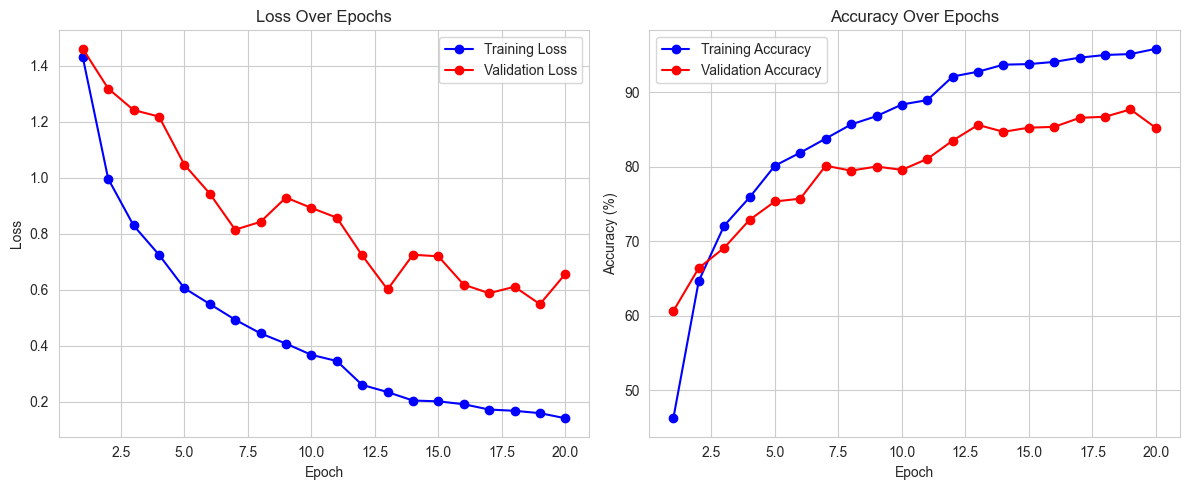

In [42]:

def plot_metrics(train_losses, train_accs, val_losses, val_accs):
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(12,5))
    
    # Plot Loss
    plt.subplot(1,2,1)
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
    plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
    plt.title("Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    
    # Plot Accuracy
    plt.subplot(1,2,2)
    plt.plot(epochs, train_accs, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_accs, 'ro-', label='Validation Accuracy')
    plt.title("Accuracy Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies)

# Grad-Cam on Sample Image

In [18]:
class GradCAM:
    def __init__(self, model, target_layer):
        """
        Args:
            model (nn.Module): Your trained model.
            target_layer (nn.Module): The layer (module) in your model where you want to visualize.
        """
        self.model = model
        self.target_layer = target_layer
        
        # placeholders for the activations and gradients
        self.activations = None
        self.gradients = None
        
        # register hooks
        self._register_hooks()
    
    def _save_activations_hook(self, module, input, output):
        self.activations = output.clone().detach()
    
    def _save_gradients_hook(self, module, grad_in, grad_out):
        # grad_out is a tuple; we want grad_out[0]
        self.gradients = grad_out[0].clone().detach()
    
    def _register_hooks(self):
        """
        Register forward and backward hooks on the target layer.
        """
        self.target_layer.register_forward_hook(self._save_activations_hook)
        self.target_layer.register_backward_hook(self._save_gradients_hook)
    
    def generate_cam(self, input_tensor, class_idx=None):
        """
        Args:
            input_tensor (torch.Tensor): A batch of images, shape (B, C, H, W).
            class_idx (int, optional): The class index for which we compute Grad-CAM.
                                       If None, we use the predicted class of the first sample.
        Returns:
            cam (numpy.ndarray): The heatmap (H, W) in [0,1] range for the first image in the batch.
        """
        # Forward pass
        output = self.model(input_tensor)  # shape (B, num_classes)
        
        if class_idx is None:
            # Use the predicted class of the first sample
            class_idx = output.argmax(dim=1)[0].item()
        
        # Zero existing gradients
        self.model.zero_grad()
        
        # Backward pass for the chosen class
        # We pick the first sample in the batch for demonstration
        target = output[0, class_idx]
        target.backward()
        
        # Get the gradients and activations we saved
        gradients = self.gradients[0]      # shape (num_filters, H', W')
        activations = self.activations[0]  # shape (num_filters, H', W')
        
        # Compute the mean of the gradients for each filter
        alpha = gradients.mean(dim=(1, 2), keepdim=True)  # shape (num_filters, 1, 1)
        
        # Weighted sum of activations
        weighted_activations = alpha * activations
        cam = weighted_activations.sum(dim=0)  # shape (H', W')
        
        # ReLU
        cam = torch.clamp(cam, min=0)
        
        # Normalize to [0,1] for visualization
        cam -= cam.min()
        cam /= (cam.max() + 1e-8)
        cam_np = cam.detach().cpu().numpy()
        
        return cam_np  # shape (H', W'), in [0,1]

  # example if your last block is layer4
# or for a custom CNN: target_layer = model.conv3

/Users/binit/PycharmProjects/FinalProject/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


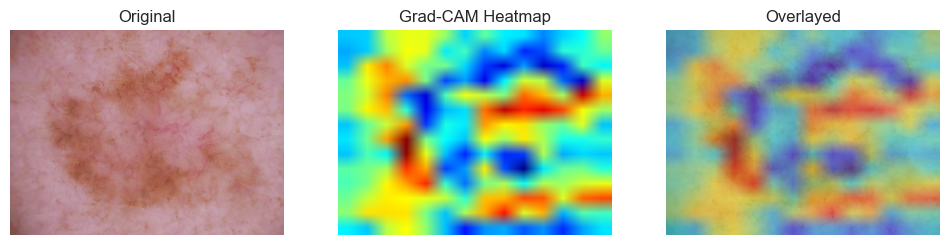

In [48]:

# 1. Load your model checkpoint
model_path = "/Users/binit/PycharmProjects/FinalProject/Project_File/model_checkpoint/cnn_attn_chk_pt/best_model_epoch_6.pth"
# Instantiate your model with the same architecture as during training.
model_chk = ResNetAttention(
    block=BasicBlock,
    layers=[2,2,2,1],  # Must match your training configuration.
    num_classes=7,
    use_cbam=True,
    use_multihead=True
).to(device)
model_chk.load_state_dict(torch.load(model_path, map_location=device))
model_chk.eval()

# state_dict = model_chk.state_dict()
# for key, value in state_dict.items():
#     if value.dtype.is_floating_point:
#         # It's a floating-point tensor, so mean() and std() are valid
#         print(f"{key}: shape={value.shape}, "
#               f"mean={value.mean().item():.4f}, "
#               f"std={value.std().item():.4f}")
#     else:
#         # It's an integer or bool tensor; skip or handle differently
#         print(f"{key}: shape={value.shape}, dtype={value.dtype}, (skipped mean/std)")

# 2. Define the target layer for Grad-CAM. For example, using the last conv in layer3:
#target_layer = model_chk.layer3[-1].conv2
target_layer = model_chk.mha

# 3. Create a GradCAM instance (assuming you have implemented GradCAM as described earlier)
gradcam = GradCAM(model_chk, target_layer)

# 4. Prepare an input image
test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])

img_path = "/Users/binit/PycharmProjects/FinalProject/Project_File/data/HAM10000_images_part_2/ISIC_0029318.jpg"
pil_img = Image.open(img_path).convert("RGB")
input_tensor = test_transform(pil_img).unsqueeze(0)  # shape: (1, 3, 224, 224)
input_tensor = input_tensor.to(device)

# 5. Generate the Grad-CAM heatmap
cam_np = gradcam.generate_cam(input_tensor, class_idx=None)  # shape: (H', W')

# 6. Overlay the heatmap on the original image
heatmap = cv2.applyColorMap(np.uint8(255 * cam_np), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
heatmap = cv2.resize(heatmap, (pil_img.width, pil_img.height))
original_np = np.array(pil_img)
overlayed = cv2.addWeighted(original_np, 0.5, heatmap, 0.5, 0)

# 7. Display the results
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.title("Original")
plt.imshow(pil_img)
plt.axis('off')

plt.subplot(1,3,2)
plt.title("Grad-CAM Heatmap")
plt.imshow(heatmap)
plt.axis('off')

plt.subplot(1,3,3)
plt.title("Overlayed")
plt.imshow(overlayed)
plt.axis('off')
plt.show()

In [47]:
model_chk.mha

MultiHeadAttention2D(
  (query_conv): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (key_conv): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (value_conv): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (softmax): Softmax(dim=-1)
)